In [ ]:
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from xgboost import XGBRegressor
from joblib import Parallel, delayed
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from joblib import dump

In [2]:
data = loadmat('../../data/data_T1_Q32_P8_400k.mat')
input_noisy = data['input_noisy']
ref = data['ref']
no_comp = data['no_comp']

In [ ]:
X = np.vstack([input_noisy, no_comp.T]).T
y = ref.T

In [ ]:
X_reduced, _, y_reduced, _ = train_test_split(X, y, train_size=0.3, random_state=42)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=42)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Reduce dimensionality using PCA to speed up processing
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    'XGBoost': XGBRegressor(
        n_estimators=100, 
        learning_rate=0.1, 
        tree_method='gpu_hist',
        gpu_id=0,
        random_state=42
    ),
    'KNN': KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
}

In [9]:
def train_and_evaluate(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = root_mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Started cross-validation for {name}")
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    cv_rmse = np.sqrt(-cv_scores)
    print(f"Finished cross-validation for {name}")

    return {
        'name': name,
        'model': model,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'CV RMSE': cv_rmse.mean(),
        'CV RMSE Std': cv_rmse.std(),
        'y_pred': y_pred,
    }

In [10]:
results = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(name, model, X_train_pca, y_train, X_test_pca, y_test) for name, model in models.items())

In [11]:
results_df = pd.DataFrame(results)
results_df = results_df.set_index('name')
results_df = results_df.drop('model', axis=1)
results_df = results_df.drop('y_pred', axis=1)

print("Model Comparison:")
print(results_df)

Model Comparison:
                    MSE      RMSE        R2   CV RMSE  CV RMSE Std
name                                                              
Random Forest  0.002478  0.049779  0.451660  0.049649     0.000174
XGBoost        0.002245  0.047381  0.503161  0.047270     0.000154
KNN            0.002627  0.051252  0.418801  0.051046     0.000139


In [12]:
# Select best model
best_model = min(results, key=lambda x: x['RMSE'])
print(f"\nBest Model: {best_model['name']}")
print(f"Best RMSE: {best_model['RMSE']:.4f}")


Best Model: XGBoost
Best RMSE: 0.0474


In [ ]:
dump(best_model['model'], f'saved_models/best_model_{best_model["name"]}.joblib')
print(f"Best model saved as 'best_model_{best_model['name']}.joblib'")

Best model saved as 'best_model_XGBoost.joblib'


d:\Proton Drive\My files\Schule\Master\Masterarbeit\project\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:03:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [14]:
def plot_spectra(y_true, y_pred, model_name, num_samples=5):
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.2)

    fig, axes = plt.subplots(num_samples, 1, figsize=(15, 6*num_samples))
    
    fig.suptitle(f'{model_name}: Ground Truth vs Predicted Spectra', fontsize=20)

    colors = sns.color_palette("husl", 2)

    for i in range(num_samples):
        sample_idx = np.random.randint(0, y_true.shape[0])
        
        df = pd.DataFrame({
            'Spectrum Index': range(len(y_true[sample_idx])),
            'Ground Truth': y_true[sample_idx],
            'Predicted': y_pred[sample_idx]
        })
        
        df_melted = pd.melt(df, id_vars=['Spectrum Index'], var_name='Type', value_name='Intensity')
        
        sns.lineplot(data=df_melted, x='Spectrum Index', y='Intensity', hue='Type', style='Type',
                     palette=colors, ax=axes[i] if num_samples > 1 else axes)
        
        current_ax = axes[i] if num_samples > 1 else axes
        current_ax.set_title(f'Sample {i+1}', fontsize=16, pad=5)
        current_ax.legend(title='')
        current_ax.set_xlabel('Spectrum Index', fontsize=12)
        current_ax.set_ylabel('Intensity', fontsize=12)
        
        sns.despine(ax=current_ax)

    plt.tight_layout()
    fig.subplots_adjust(top=1.0)
    plt.show()

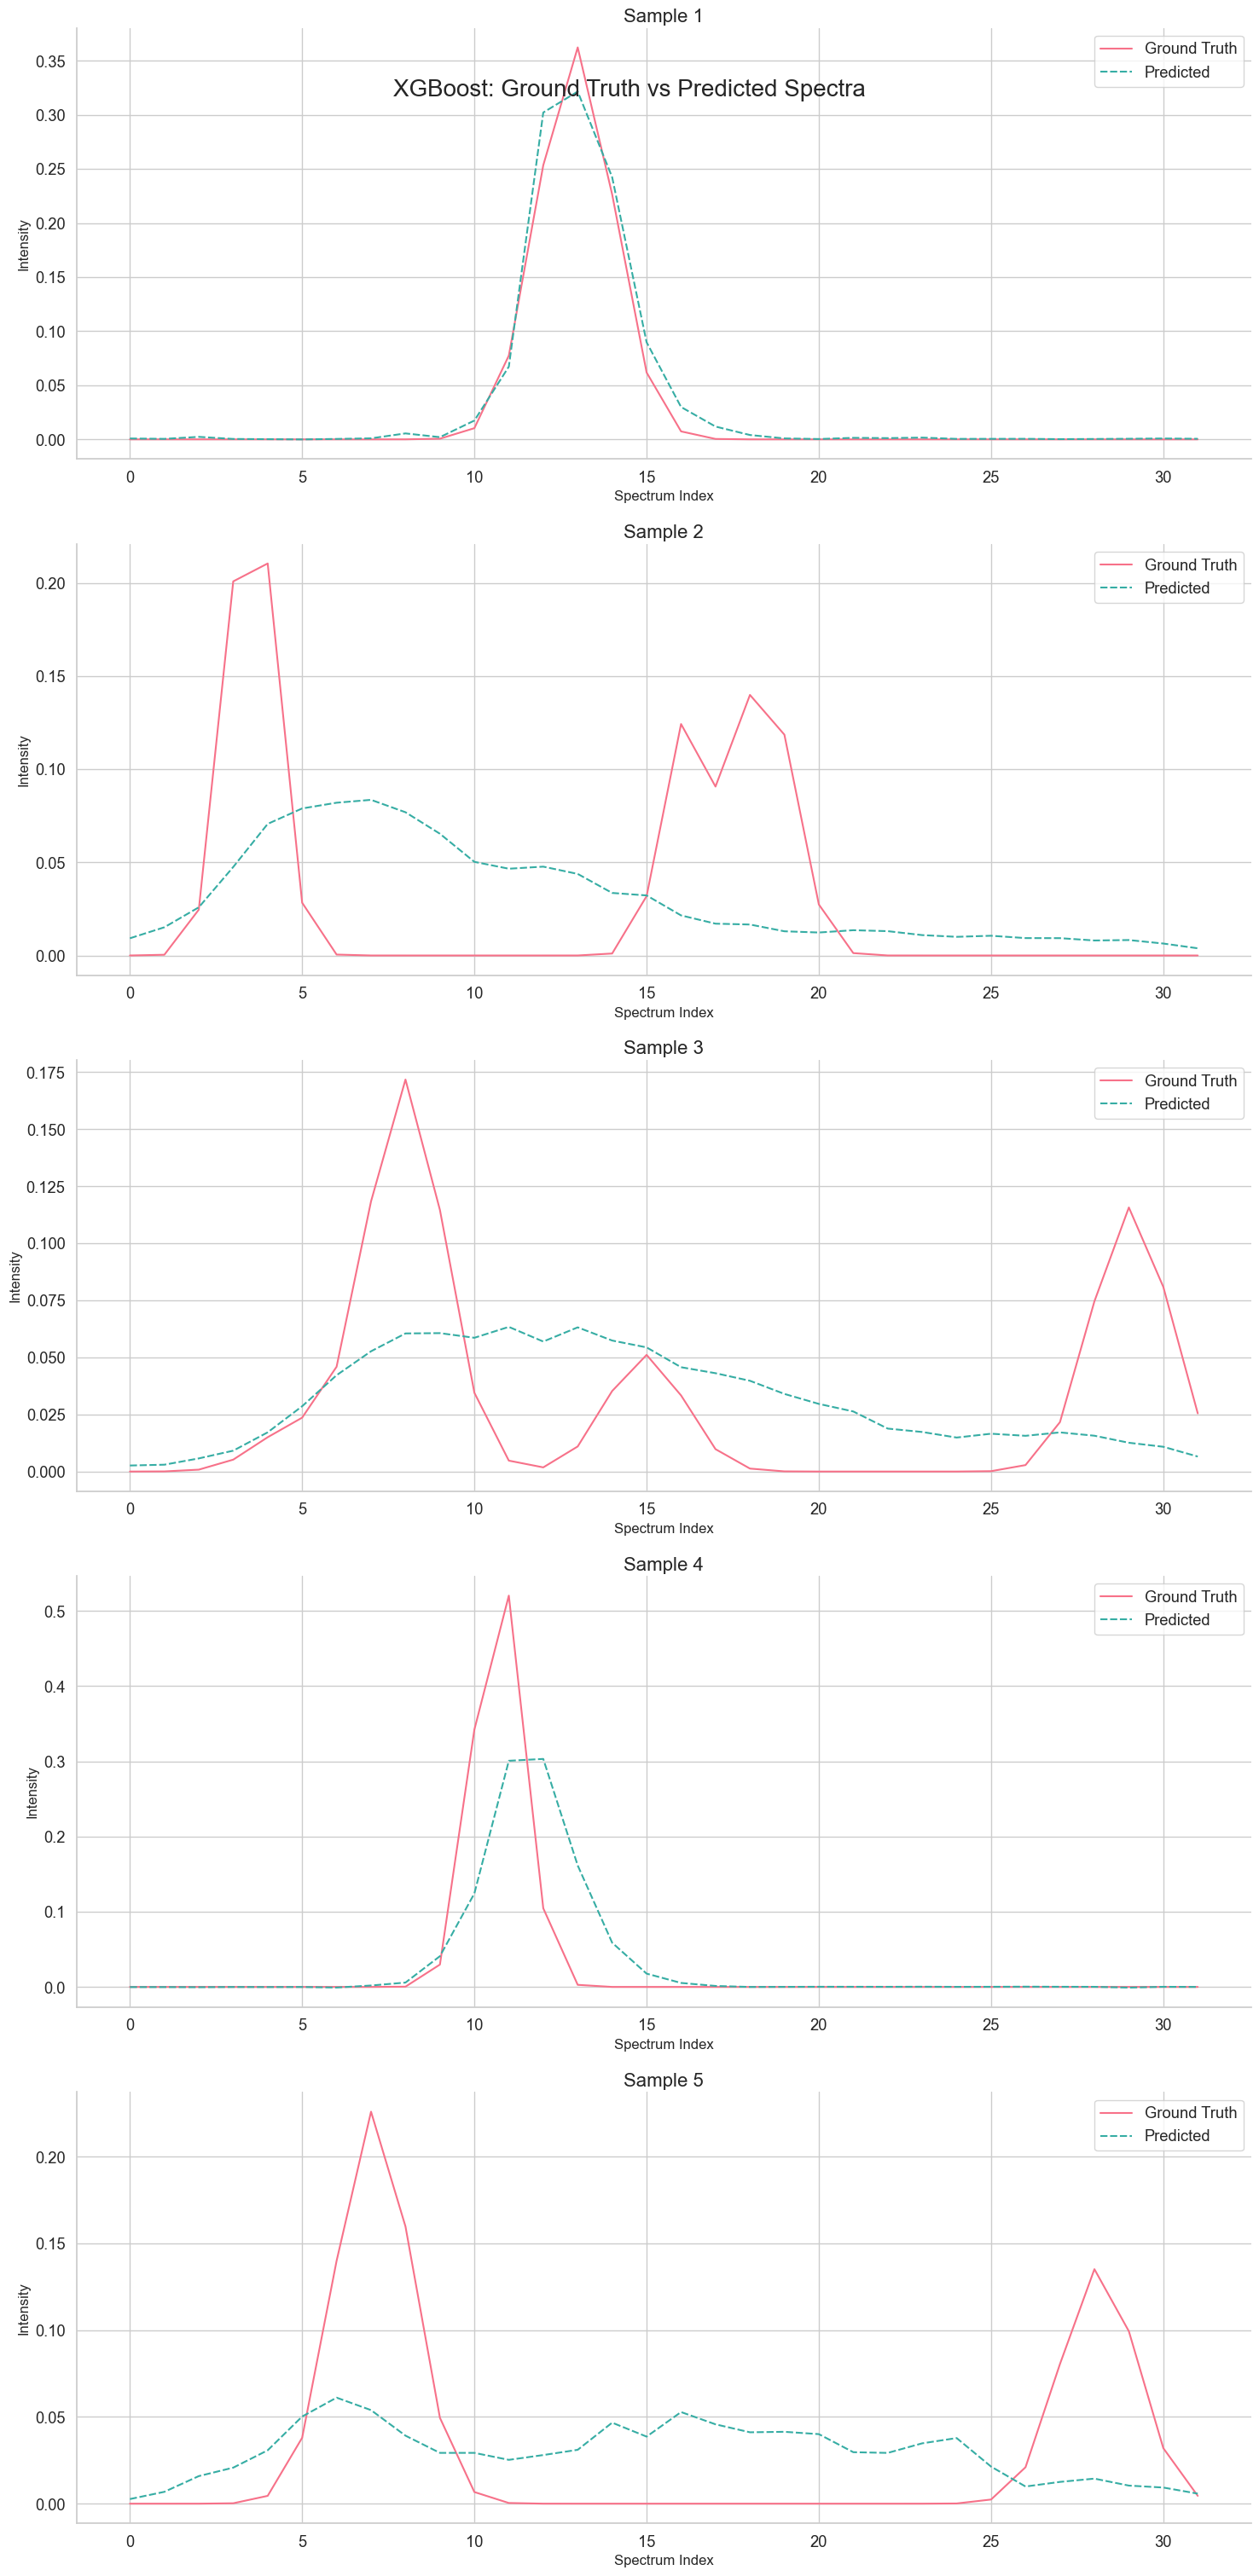

In [15]:
plot_spectra(y_test, best_model['y_pred'], best_model['name'])

In [ ]:
def peak_metrics(y_true, y_pred):
    true_peaks = np.argmax(y_true, axis=1)
    pred_peaks = np.argmax(y_pred, axis=1)
    
    peak_accuracy = np.mean(true_peaks == pred_peaks)
    mean_peak_error = np.mean(np.abs(true_peaks - pred_peaks))
    
    print(f"Peak Accuracy: {peak_accuracy:.4f}")
    print(f"Mean Peak Error: {mean_peak_error:.4f}")

print("\nPeak Metrics for the Best Model:")
peak_metrics(y_test, best_model['y_pred'])


Peak Metrics for the Best Model:
Peak Accuracy: 0.2787
Mean Peak Error: 2.8610
